In [1]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

In [3]:
#Initialisation des données
delta = [0.1, 0.]
T= 5000 #Nb max d'iterations
runs = 100 #number of 
p = np.array([0.8, 0.9]) #Param des Bernoulli
K = p.shape[0] #Nb de bras

alpha=3

## UCB

In [4]:
sub_arm_list_ucb = []
start_time = time.time()

for run in range(runs):
    if(run == 0 or run % 1000 == 0):
        print("run =", run)
    
    #ucb Params Iinitialization
    N = np.zeros(K) #Nb de fois ou le bras 1 ou 2 a été tiré
    rewards_ucb = np.zeros((K, T), dtype=np.int) #Recompense avec chaque bras
    action_ucb = np.zeros((K, T), dtype=np.int) #Bras choisi a chaque étape
    ucb = np.zeros(K) #ucb pour chaque bras

    #On commence en explorant les 2 bras au moins une fois
    #t between 0 & K
    for t in range(K):
        N[t]=1
        rewards_ucb[t,t]= np.random.binomial(1, p[t])
        action_ucb[t,t]=1

    #t >= K
    for t in range(K, T):
        for k in range(K):
            ucb[k] = np.sum(rewards_ucb[k,:t])/N[k]+np.sqrt((alpha*math.log(t))/(2*N[k]))

        select = np.argmax(ucb)
        N[select] += 1
        action_ucb[select,t] = 1
        rewards_ucb[select,t] = np.random.binomial(1,p[select])

    sub_arm = np.copy(action_ucb[0,])
    #print(sub_arm)
    sub_arm_list_ucb.append(sub_arm)

print("Time for UCB, with T =", T, ", runs =", runs, ":", (time.time() - start_time), "seconds")
#NB: would take 300hrs for
#T= 2*10**4
#runs = 50*10**3 

run = 0
Time for UCB, with T = 5000 , runs = 100 : 58.397037744522095 seconds


In [5]:
mean_sub_arm = np.mean(sub_arm_list_ucb, axis=0 ) #Mean number of the suboptimal arm as a function of time
sub_arm_draws_T = np.zeros(runs) #number of draws of the suboptimal arm at tim n=5000
for i in range(runs):
    sub_arm_draws_T[i] = np.sum(sub_arm_list_ucb[i][:5000])

## KL-UCB

In [8]:
%%capture
# KL-UCB avec 2 bras
klucb = kl_ucb_policy.KLUCBPolicy(K)

sub_arm_list_klucb = []
start_time = time.time()

for run in range(runs):
    if(run == 0 or run % 10 == 0):
        print("run =", run)
        
    klucb.reset()
    actions_klucb = np.zeros((K, T), dtype=np.int)
    rewards_klucb = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm_klucb = klucb.select_next_arm()
        #print("arm :", arm)
        actions_klucb[arm_klucb,t] = 1
        rewards_klucb[arm_klucb,t] = np.random.binomial(1, p[arm_klucb])
        klucb.update_state(arm_klucb, rewards_klucb[arm_klucb,t])
        
    sub_arm = np.copy(actions_klucb[0,])
    #print(sub_arm)
    sub_arm_list_klucb.append(sub_arm)

time_spent = time.time() - start_time

In [9]:
print("Time for KL-UCB, with T =", T, ", runs =", runs, ":", (time_spent), "seconds")
#NB: would take 300hrs for
#T= 2*10**4
#runs = 50*10**3 

Time for KL-UCB, with T = 5000 , runs = 100 : 67.06213998794556 seconds


In [10]:
mean_sub_arm_klucb = np.mean(sub_arm_list_klucb, axis=0 ) #Mean number of the suboptimal arm as a function of time
sub_arm_draws_T_klucb = np.zeros(runs) #number of draws of the suboptimal arm at tim n=5000
for i in range(runs):
    sub_arm_draws_T_klucb[i] = np.sum(sub_arm_list_klucb[i][:5000])

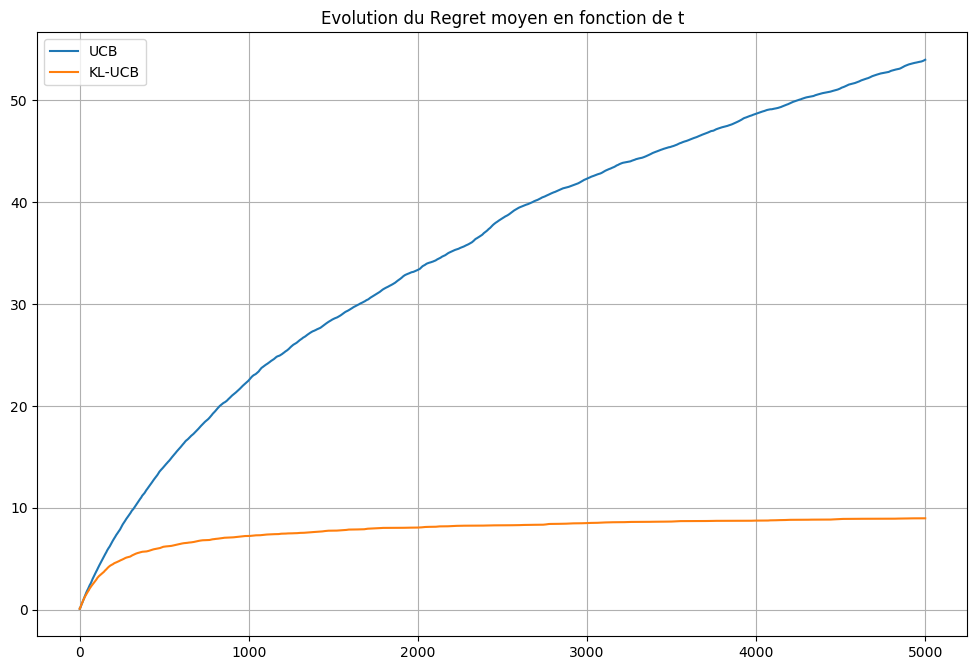

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.cumsum(mean_sub_arm)*delta[0], linestyle='-', label='UCB')
ax.plot(np.cumsum(mean_sub_arm_klucb)*delta[0], linestyle='-', label='KL-UCB')
ax.grid(True)
ax.legend(loc='best')
ax.set_title('Evolution du Regret moyen en fonction de t')
#plt.xlim( 10**2, 2*10**4 ) 
plt.show()

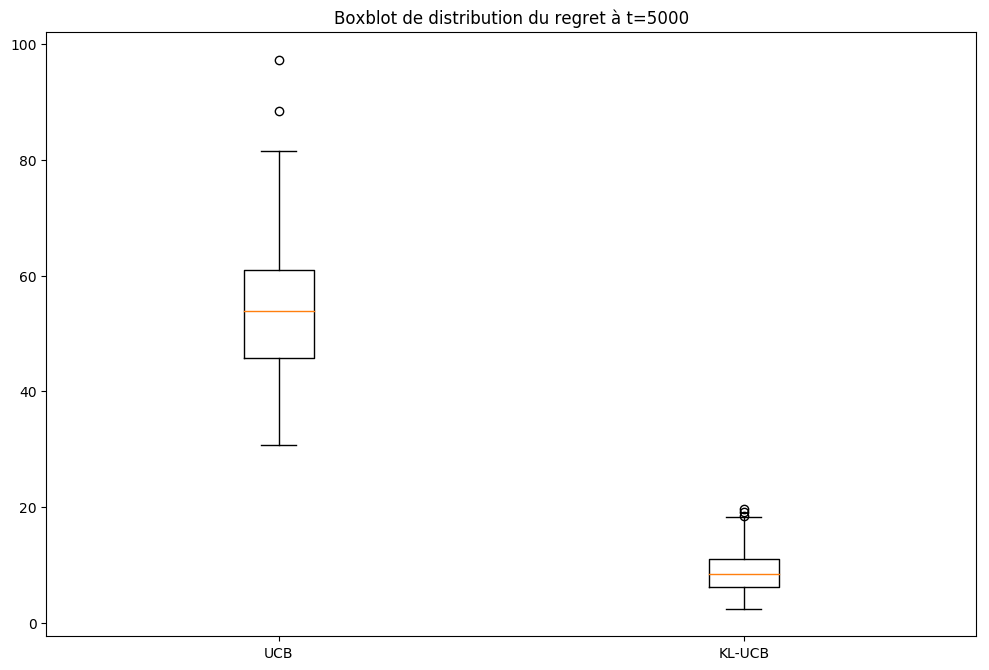

In [12]:
#Plot Article's figure 1 (right)
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.boxplot([sub_arm_draws_T*delta[0], sub_arm_draws_T_klucb*delta[0]])
ax.set_xticklabels(['UCB', 'KL-UCB'])
#ax.legend(loc='best')
ax.set_title('Boxplot de distribution du regret à t='+str(T))
plt.show()

In [19]:
#If already something in data file
#ucb
file_ucb = 'data/ucb_scenario_1.pkl'
#read
read_ucb = open(file_ucb, 'rb')
parameters_ucb = pickle.load(read_ucb)
read_ucb.close()
#update
parameters_ucb['sub_arm_list'] += sub_arm_list_ucb
#write
write_ucb = open(file_ucb, 'wb')
pickle.dump(parameters_ucb, write_ucb)
write_ucb.close()